In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

In [2]:
# Load and preprocess the data
df = pd.read_csv('BATS_AAPL.csv')
df['date'] = pd.to_datetime(df['time'])
df.set_index('date', inplace=True)

# Use only the 'close' price for prediction
data = df[['close']].copy()

C:\Users\nhuth\AppData\Local\Temp\ipykernel_18604\1574937484.py:3: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df['date'] = pd.to_datetime(df['time'])


In [3]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Create a function to prepare sequences for LSTM
def create_sequences(dataset, seq_length):
    X, y = [], []
    for i in range(seq_length, len(dataset)):
        X.append(dataset[i - seq_length:i, 0])
        y.append(dataset[i, 0])
    return np.array(X), np.array(y)

sequence_length = 60
X, y = create_sequences(scaled_data, sequence_length)

In [4]:
# Reshape X for LSTM: [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Split into training and testing sets (80/20)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [5]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

C:\Users\nhuth\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [6]:
# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32)

Epoch 1/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 24s 37ms/step - loss: 0.0095
Epoch 2/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 20s 38ms/step - loss: 5.0464e-05
Epoch 3/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 22s 41ms/step - loss: 4.9946e-05
Epoch 4/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - loss: 4.6907e-05
Epoch 5/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - loss: 3.7711e-05
Epoch 6/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - loss: 3.5846e-05
Epoch 7/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - loss: 3.5817e-05
Epoch 8/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 20s 38ms/step - loss: 3.4285e-05
Epoch 9/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 26s 50ms/step - loss: 2.8247e-05
Epoch 10/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 21s 39ms/step - loss: 2.8704e-05
Epoch 11/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 20s 37ms/step - loss: 2.7744e-05
Epoch 12/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 23s 44ms/step - loss: 2.4299e-05
Epoch 13/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - loss: 2.4474e-05
Epoch 14/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/s

In [7]:
# Make predictions and inverse scale
predicted = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted.reshape(-1, 1))
actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

133/133 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step


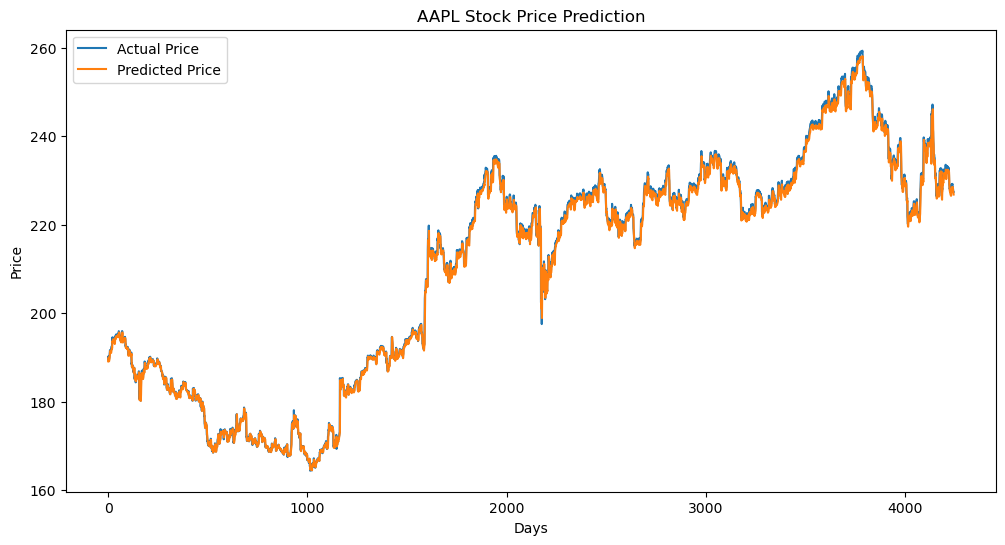

In [8]:
#  Plot the results
plt.figure(figsize=(12,6))
plt.plot(actual_prices, label='Actual Price')
plt.plot(predicted_prices, label='Predicted Price')
plt.title('AAPL Stock Price Prediction')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.show()

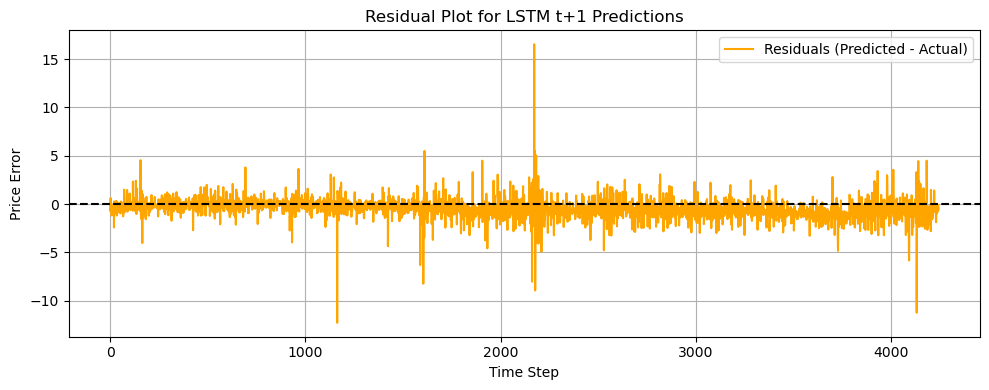

In [9]:
# Calculate residuals
residuals = predicted_prices.flatten() - actual_prices.flatten()

# Plot residuals
plt.figure(figsize=(10, 4))
plt.plot(residuals, label='Residuals (Predicted - Actual)', color='orange')
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Residual Plot for LSTM t+1 Predictions')
plt.xlabel('Time Step')
plt.ylabel('Price Error')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [37]:
def classify_movement(p_now, p_future):
    pct_change = (p_future - p_now) / p_now * 100
    if pct_change > 0.8:
        return "strong_bullish"
    elif pct_change > 0.4:
        return "medium_bullish"
    elif pct_change > 0.1:
        return "small_bullish"
    elif pct_change < -0.8:
        return "strong_bearish"
    elif pct_change < -0.4:
        return "medium_bearish"
    elif pct_change < -0.1:
        return "small_bearish"
    else:
        return "neutral"

In [38]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
def evaluate_trend(p_now, y_pred, y_true, title):
    pred_labels = [classify_movement(p, y_hat) for p, y_hat in zip(p_now, y_pred)]
    true_labels = [classify_movement(p, y_real) for p, y_real in zip(p_now, y_true)]
    print(f"\\n=== {title} ===")
    print("Accuracy:", accuracy_score(true_labels, pred_labels))
    print(classification_report(true_labels, pred_labels))

    labels = ["strong_bearish", "medium_bearish", "small_bearish", "neutral",
              "small_bullish", "medium_bullish", "strong_bullish"]
    cm = confusion_matrix(true_labels, pred_labels, labels=labels)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title(f'Confusion Matrix - {title}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

\n=== t+1 Prediction ===
Accuracy: 0.7336659539082917
                precision    recall  f1-score   support

medium_bearish       0.32      0.33      0.33       332
medium_bullish       0.48      0.41      0.44       287
       neutral       0.30      0.24      0.27       221
 small_bearish       0.33      0.34      0.34       303
 small_bullish       0.36      0.30      0.33       253
strong_bearish       0.86      0.97      0.91      1583
strong_bullish       0.96      0.89      0.92      1230

      accuracy                           0.73      4209
     macro avg       0.52      0.50      0.51      4209
  weighted avg       0.72      0.73      0.73      4209



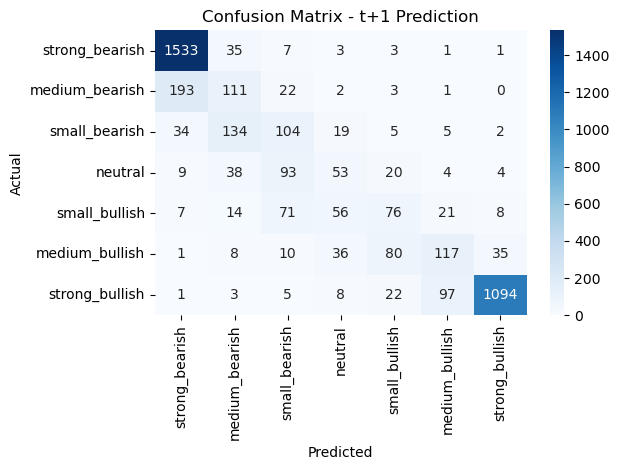

In [39]:
evaluate_trend(current_prices, predicted_prices, actual_prices, "t+1 Prediction")

In [41]:
def classify_movement_simple(p_now, p_future, threshold=0.1):
    pct_change = (p_future - p_now) / p_now * 100
    if pct_change > threshold:
        return "bullish"
    elif pct_change < -threshold:
        return "bearish"
    else:
        return "neutral"

In [42]:
def evaluate_trend_simple(p_now, p_pred, p_true, title, threshold=0.1):
    pred_labels = [classify_movement_simple(p, y_hat, threshold) for p, y_hat in zip(p_now, p_pred)]
    true_labels = [classify_movement_simple(p, y_real, threshold) for p, y_real in zip(p_now, p_true)]
    
    print(f"\n=== {title} ===")
    print("Accuracy:", accuracy_score(true_labels, pred_labels))
    print(classification_report(true_labels, pred_labels))

    labels = ["bearish", "neutral", "bullish"]
    cm = confusion_matrix(true_labels, pred_labels, labels=labels)

    # Plot
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.title(f"Confusion Matrix - {title}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()


=== t+1 Prediction (3-Class) ===
Accuracy: 0.8971252078878593
              precision    recall  f1-score   support

     bearish       0.89      0.98      0.93      2218
     bullish       0.97      0.88      0.92      1770
     neutral       0.30      0.24      0.27       221

    accuracy                           0.90      4209
   macro avg       0.72      0.70      0.71      4209
weighted avg       0.89      0.90      0.89      4209



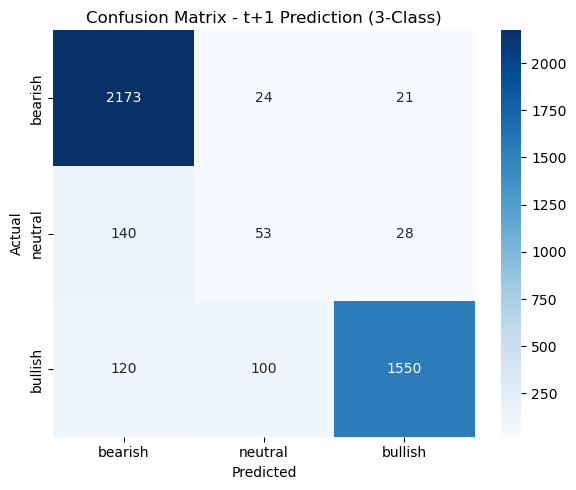

In [43]:
evaluate_trend_simple(current_prices, predicted_prices, actual_prices, "t+1 Prediction (3-Class)")

### Predict with time t + 2 and technical analysis

In [17]:
# Drop initial NaNs
df = pd.read_csv('BATS_AAPL.csv')
df['date'] = pd.to_datetime(df['time'])
df.set_index('date', inplace=True)

C:\Users\nhuth\AppData\Local\Temp\ipykernel_18604\1387673283.py:3: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df['date'] = pd.to_datetime(df['time'])


In [19]:
feature_cols = ['close', 'RSI', 'MACD', 'Histogram']
df[feature_cols].head()
df = df[feature_cols].dropna()

In [20]:
scaled_data = scaler.fit_transform(df)

X2, y2 = [], []
for i in range(sequence_length, len(scaled_data) - 2):  # t+2
    X2.append(scaled_data[i - sequence_length:i])
    y2.append(scaled_data[i + 2][0])  # Predict close price at t+2

X2, y2 = np.array(X2), np.array(y2)

In [21]:
X2_train, X2_test = X2[:train_size], X2[train_size:]
y2_train, y2_test = y2[:train_size], y2[train_size:]

model2 = Sequential()
model2.add(LSTM(units=50, return_sequences=True, input_shape=(X2.shape[1], X2.shape[2])))
model2.add(LSTM(units=50))
model2.add(Dense(1))
model2.compile(optimizer='adam', loss='mean_squared_error')

model2.fit(X2_train, y2_train, epochs=20, batch_size=32)

# Predict and inverse scale
y2_pred = model2.predict(X2_test)
y2_pred_prices = scaler.inverse_transform(np.hstack([y2_pred, np.zeros((len(y2_pred), len(feature_cols) - 1))]))[:, 0]
y2_actual_prices = scaler.inverse_transform(np.hstack([y2_test.reshape(-1, 1), np.zeros((len(y2_test), len(feature_cols) - 1))]))[:, 0]

Epoch 1/20


C:\Users\nhuth\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


531/531 ━━━━━━━━━━━━━━━━━━━━ 23s 36ms/step - loss: 0.0076
Epoch 2/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 18s 34ms/step - loss: 5.3356e-05
Epoch 3/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 20s 38ms/step - loss: 5.1011e-05
Epoch 4/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 25s 46ms/step - loss: 5.4712e-05
Epoch 5/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 18s 33ms/step - loss: 5.1902e-05
Epoch 6/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 20s 38ms/step - loss: 5.2145e-05
Epoch 7/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 21s 40ms/step - loss: 5.3468e-05
Epoch 8/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - loss: 5.4926e-05
Epoch 9/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 28s 54ms/step - loss: 4.8853e-05
Epoch 10/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 26s 49ms/step - loss: 5.1357e-05
Epoch 11/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 28s 53ms/step - loss: 4.7588e-05
Epoch 12/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 18s 34ms/step - loss: 4.9945e-05
Epoch 13/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 20s 38ms/step - loss: 4.1410e-05
Epoch 14/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 26s 48ms/step - loss:

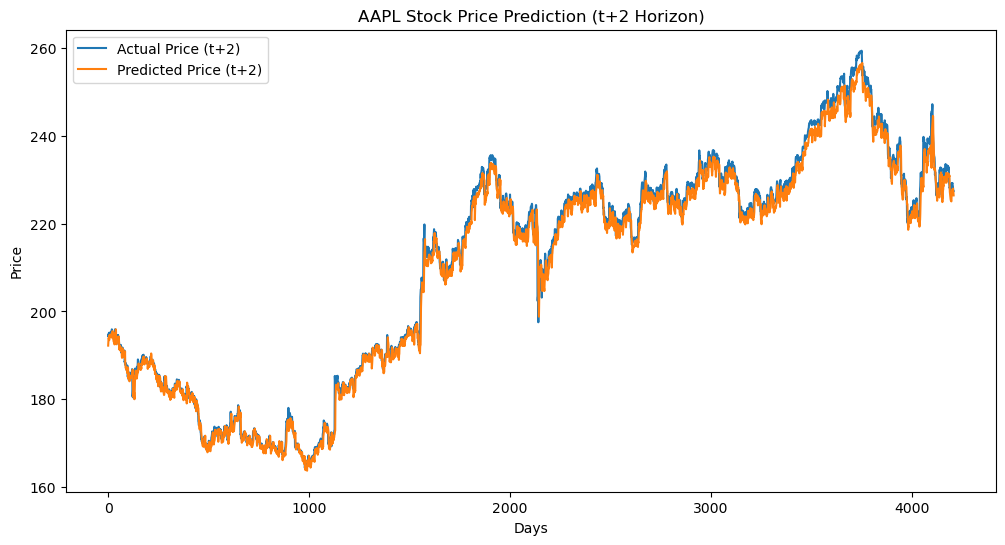

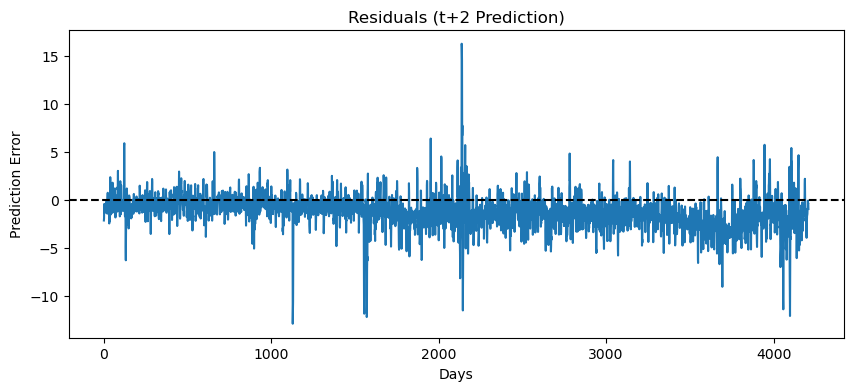

In [22]:
plt.figure(figsize=(12, 6))
plt.plot(y2_actual_prices, label='Actual Price (t+2)')
plt.plot(y2_pred_prices, label='Predicted Price (t+2)')
plt.title('AAPL Stock Price Prediction (t+2 Horizon)')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.show()

# Optional: Residual plot
residuals = y2_pred_prices - y2_actual_prices
plt.figure(figsize=(10, 4))
plt.plot(residuals)
plt.title('Residuals (t+2 Prediction)')
plt.xlabel('Days')
plt.ylabel('Prediction Error')
plt.axhline(0, color='black', linestyle='--')
plt.show()

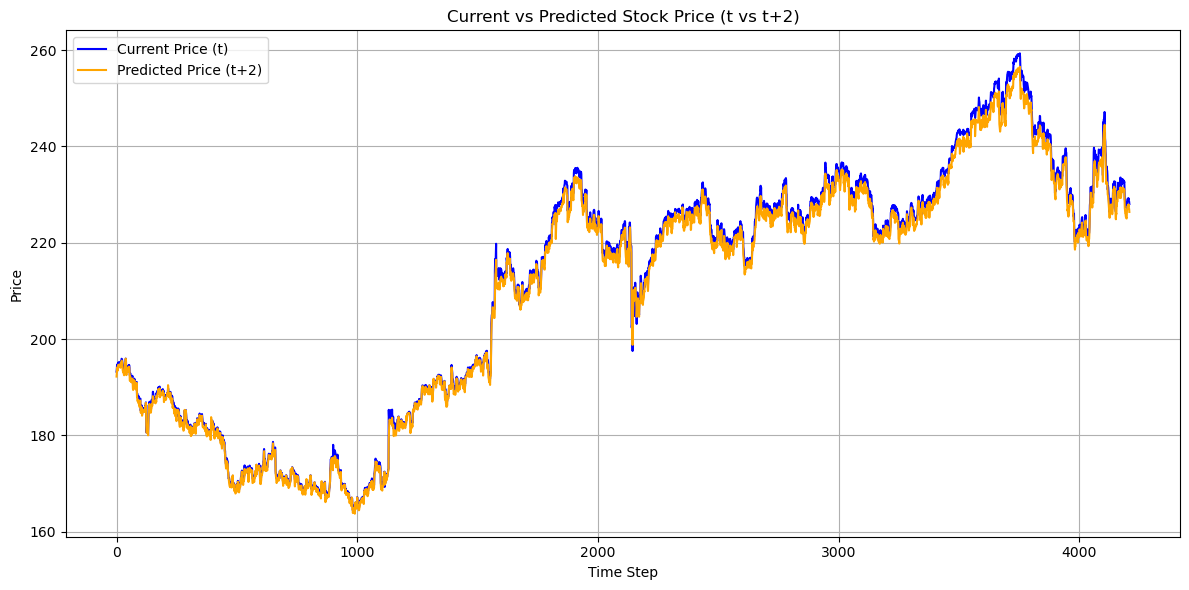

In [23]:
# Recover the actual current close price at time t (from X2_test)
# We'll inverse transform the last value in each input sequence
current_prices_scaled = X2_test[:, -1, 0].reshape(-1, 1)  # last close price in each input sequence
current_prices = scaler.inverse_transform(
    np.hstack([current_prices_scaled, np.zeros((len(current_prices_scaled), 3))])
)[:, 0]  # Inverse only the 'close' column

# Plot current t vs predicted t+2
plt.figure(figsize=(12, 6))
plt.plot(current_prices, label='Current Price (t)', color='blue')
plt.plot(y2_pred_prices, label='Predicted Price (t+2)', color='orange')
plt.title('Current vs Predicted Stock Price (t vs t+2)')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


\n=== t+2 Prediction ===
Accuracy: 0.13186029935851745
                precision    recall  f1-score   support

medium_bearish       0.09      0.50      0.16       405
medium_bullish       0.00      0.00      0.00       511
       neutral       0.20      0.03      0.05       900
 small_bearish       0.21      0.28      0.24       812
 small_bullish       0.29      0.01      0.01       914
strong_bearish       0.11      0.25      0.15       343
strong_bullish       0.33      0.00      0.01       324

      accuracy                           0.13      4209
     macro avg       0.18      0.15      0.09      4209
  weighted avg       0.19      0.13      0.09      4209



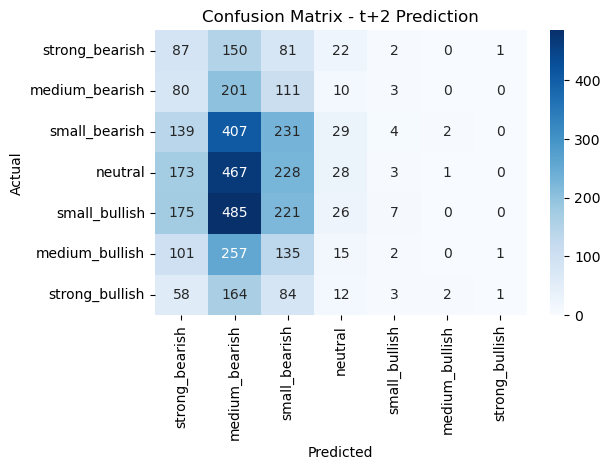

In [40]:
evaluate_trend(current_prices, y2_pred_prices, y2_actual_prices, "t+2 Prediction")